<a href="https://colab.research.google.com/github/Caumel/TFG_Software/blob/master/TFG_Software_DogCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes neuronales siamesas**

## **Preparacion codigo**

### **Importando modulos necesarios**

In [0]:
import tensorflow as tf
import random
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image as img
import cv2
from keras.optimizers import Adam

from __future__ import absolute_import,division,print_function

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Activation
from keras.optimizers import SGD, RMSprop
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda
from keras.preprocessing import image

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score as accuracy


Using TensorFlow backend.


### **Funcion para calcular la distantica L1 punto a punto entre dos vectores y triplet loss**

In [0]:
                        
def abs_diff_output_shape(input_shapes):
  shape1, shape2, shape3= input_shapes
  return shape1
  #shape1 = input_shapes[0]
  #shape2 = input_shapes[1]
  #assert shape1 == shape2  # else hadamard product isn't possible
  #return [shape1, shape2]

def distance_vec(y_pred): #Cosine distance
  x = y_pred[0]
  y = y_pred[1]
  z = y_pred[2]
  negative = K.prod(K.stack([x, y], axis=1), axis=1)
  return negative
  
  #anchor = y_pred[0]
  #positive = y_pred[1]
  #negative = y_pred[2]

  #positive_distance = K.abs(anchor-positive) #En principio mean y sum hacen lo mismo excepto que una hace media y otro suma
  #negative_distance = K.abs(anchor-negative)
  #return [positive_distance, negative_distance]
  #return positive_distance - negative_distance

def get_abs_diff(y_pred):
    # L1 distance between two vectors
    x = y_pred[0]
    y = y_pred[1]
    z = y_pred[2]
    return K.abs(x - y)

def triple_loss(y_true, y_pred):   # y_pred contiene la imagen ancla, positiva y negativa
  alpha = 0.1
  
  anchor = y_pred[0]
  positive = y_pred[1]
  negative = y_pred[2]
    
  positive_distance = K.mean(K.square(anchor-positive),axis=-1)  #En principio mean y sum hacen lo mismo excepto que una hace media y otro suma
  negative_distance = K.mean(K.square(anchor-negative),axis=-1)
  
  loss = positive_distance - negative_distance
  return K.maximum(loss + alpha, 0)   

### **Funcion para crear tripletas y cargar las imagenes**



In [0]:
def get_random_image(img_groups, group_names, gid):
  #print(gid)
  gname = group_names[gid]
  #print(gname)
  photos = img_groups[gname]
  pid = np.random.choice(np.arange(len(photos)), size=1)[0]
  pname = photos[pid]
  return gname[0:3] + "." + pname + ".jpg"
   
def create_triplet(number_images): # Crea tripleta
  img_groups = {}
  for folder in  os.listdir('/content/drive/My Drive/TFG software/dog vs cat/dataset/training_set/'):
    i = 0 
    for img_file in os.listdir('/content/drive/My Drive/TFG software/dog vs cat/dataset/training_set/' + folder):
      if i == number_images: # Para solo coger 40 fotos
        break
      prefix, suffix, ext = img_file.split(".")
      if folder in img_groups:
          img_groups[folder].append(suffix)
      else:
          img_groups[folder] = [suffix]
      i += 1
  pos_triples = []
  # positive pairs and negative 
  group_names = list(img_groups.keys())
  for key in img_groups.keys():
    for i in range(0,number_images):
      for j in range(i+1,number_images): # Si dejo i me cogeria duplas con elementos iguales osea (001,001)
        if key=='dogs':
          dn = 1
        else:
          dn = 0
        right = get_random_image(img_groups, group_names, dn)
        pos_triples.append((key[0:3] + "." + img_groups[key][i] + '.jpg', key[0:3] + "." + img_groups[key][j] + '.jpg', right))
  return pos_triples  

def load_image(image_name):
  image = cv2.imread('/content/drive/My Drive/TFG software/dog vs cat/dataset/training_set/' + image_name[0:3] + 's' + '/' + image_name)
  image = cv2.resize(image, (96, 96))
  image = img_to_array(image)
  return image    
           
def triples_batch(image_triples):#, batch_size): #Tripletas
  images = []
  for i in image_triples:
      ahs, phs, nhs= i
      images.append((load_image(ahs),load_image(phs),load_image(nhs)))
  data = np.array(images, dtype="float") / 255.0
  return data
  #return np.array(images)

### Metodo para crear pares positivos y negativos

In [0]:
def draw_image(subplot, image, title):
    plt.subplot(subplot)
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
def printimg(triples_data, labels):
  for i in triples_data:
    print(i)
    gid1 = i[0][0:3]
    gid2 = i[1][0:3]
    ref_image = plt.imread(os.path.join('/content/drive/My Drive/TFG software/dataset/' + gid1 , i[0]))
    sim_image = plt.imread(os.path.join('/content/drive/My Drive/TFG software/dataset/' + gid2 , i[1]))
    if labels[triples_data.index(i)] == 1:
      draw_image(131, ref_image, "similar")
      draw_image(132, sim_image, "similar")
      plt.tight_layout()
      plt.show()
    else:
      draw_image(131, ref_image, "different")
      draw_image(132, sim_image, "different")
      plt.tight_layout()
      plt.show() 

def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"
   
def create_pairs(): # Crea par positivo y par negativo
  img_groups = {}
  for folder in  os.listdir('/content/drive/My Drive/TFG software/dataset'):
    i = 0 
    for img_file in os.listdir('/content/drive/My Drive/TFG software/dataset/' + folder):
      if i == number_images: # Para solo coger 40 fotos
        break
      prefix, suffix = img_file.split(".")
      pid = prefix[3:]
      if folder in img_groups:
          img_groups[folder].append(pid)
      else:
          img_groups[folder] = [pid]
      i += 1
  pos_triples, neg_triples, labels = [], [], []
  # positive pairs and negative 
  group_names = list(img_groups.keys())
  for key in img_groups.keys():
    for i in range(0,number_images):
      for j in range(i+1,number_images): # Si dejo i me cogeria duplas con elementos iguales osea (001,001)
        pos_triples.append((key + img_groups[key][i] + ".jpg", key + img_groups[key][j] + ".jpg"))
        inc = random.randrange(1, classes+1)
        dn = (int(key) + inc) % classes
        right = get_random_image(img_groups, group_names, dn)
        pos_triples.append((key + img_groups[key][i] + ".jpg", right))
        labels += [1, 0]
  return pos_triples, labels  
    #for key in img_groups.keys():   # Esta parte de aqui te pone una tripleta con el ultimo elemento 1 o 0 si es pos o neg y los negativos te hace un random que no se si se repetirian los ejemplos
        #triples = [(key + x[0] + ".jpg", key + x[1] + ".jpg", 1) for x in itertools.combinations(img_groups[key], 2)]
        #pos_triples.extend(triples)    
    #need equal number of negative examples
  #group_names = list(img_groups.keys())
  #for i in range(len(pos_triples)):
      #g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
      #left = get_random_image(img_groups, group_names, g1)
      #right = get_random_image(img_groups, group_names, g2)
      #neg_triples.append((left, right, 0))
  #pos_triples.extend(neg_triples)
  #shuffle(pos_triples)
  #return pos_triples


def load_image(image_name):
    #if not image_name in image_cache:
        ##image = plt.imread(os.path.join('/content/drive/My Drive/TFG software/dataset/' + image_name[0:3] , image_name))
        #imagen = image.load_img('/content/drive/My Drive/TFG software/dataset/' + image_name[0:3] + '/' + image_name, target_size=(256, 256,3))
        ##draw_image(132, image,image_name)
        ##plt.tight_layout()
        ##plt.show()
        ##imagen = img.open('/content/drive/My Drive/TFG software/dataset/' + image_name[0:3] + '/' + image_name)
        #imagen.thumbnail(input_dim, img.ANTIALIAS)
        #imagen = np.divide(imagen, 256)
        ##imagen = plt.imshow(img/255.)
        #image_cache[image_name] = imagen   
    #return image_cache[image_name]

  image = cv2.imread('/content/drive/My Drive/TFG software/dataset/' + image_name[0:3] + '/' + image_name)
  image = cv2.resize(image, (96, 96))
  image = img_to_array(image)
  return image    
           
def dobles_batch(image_triples, batch_size, labels): #Duplas
  indices = np.arange(len(image_triples))
  shuffled_triples = [image_triples[ix] for ix in indices]
  num_batches = len(shuffled_triples) // batch_size
  for bid in range(num_batches):
    images = []
    batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]
    for i in range(batch_size):
      lhs, rhs= batch[i]
      images.append((load_image(lhs),load_image(rhs)))
  return np.array(images), np.array(labels)

### **Crear red neuronal Convolucional**


In [0]:
def create_base_network(input_dim, classes): # SmallerVGGnet
  red = Sequential() 
  red.add(Conv2D(32, (3, 3), padding="same",input_shape=input_dim))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(MaxPooling2D(pool_size=(3, 3)))
  red.add(Dropout(0.25))
  
  # (CONV => RELU) * 2 => POOL
  red.add(Conv2D(64, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(Conv2D(64, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(MaxPooling2D(pool_size=(2, 2)))
  red.add(Dropout(0.25))
  
  # (CONV => RELU) * 2 => POOL
  red.add(Conv2D(128, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(Conv2D(128, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(MaxPooling2D(pool_size=(2, 2)))
  red.add(Dropout(0.25))
  
	# first (and only) set of FC => RELU layers
  red.add(Flatten())
  red.add(Dense(1024))
  red.add(Activation("relu"))
  red.add(BatchNormalization())
  red.add(Dropout(0.5))
  
  return red 

## **Principal**

### **Inicializar datos y normalizarlos**

In [0]:
number_images = 5 # Numero de imagenes cogidas
classes = 2 # Numero de pokemones
batch = 128
nb_epoch = 5

input_dim = (96,96,3) # Son el ancho el alto y la profundidad de la imagen, 3 al ser en color es la variable input_dim pero todavia no esta tocada

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Crear varias imagenes apartir de una moviendola o rotandola

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/TFG software/dataset',  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# the data, shuffled and split between train and test sets
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train = X_train.reshape(60000, input_dim)
#X_test = X_test.reshape(10000, input_dim)
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255


In [0]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/content/drive/My Drive/TFG software/database/108.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,save_to_dir='/content/drive/My Drive/TFG software/', save_prefix='1', save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

### **Crear conjuntos de datos de entrenamiento y test** 


In [0]:
triples_data = create_triplet(number_images)

print("# image triples:", len(triples_data))

tr_train = triples_data[0:15]
tr_val = triples_data[15:20]  #El tamaño tiene que ser par (No se mucho por que)

print("# image triples:", len(tr_train))
print("# image triples:", len(tr_val))

image_cache = {}

tr_load_train = triples_batch(tr_train)
tr_load_val = triples_batch(tr_val)

# image triples: 20
# image triples: 15
# image triples: 5


In [0]:
print("# image train triples:", len(tr_train))
[x for x in tr_train[0:5]]

print("# image validation triples:", len(tr_val))
[x for x in tr_val[0:5]]

print(tr_load_train.shape)

print(tr_load_val.shape)

# image train triples: 15
# image validation triples: 5
(15, 3, 96, 96, 3)
(5, 3, 96, 96, 3)


### **Crear red siamesa** 

In [0]:
# network definition
base_network = create_base_network(input_dim, classes)
#base_network.summary()
from keras.layers import Layer

anchor_a = Input(shape=(input_dim))   #Nos da un tensor del tamaño input_dim
anchor_p = Input(shape=(input_dim))
anchor_n = Input(shape=(input_dim))


processed_a = base_network(anchor_a)
processed_p = base_network(anchor_p)
processed_n = base_network(anchor_n)

#distance = Lambda(get_abs_diff, output_shape=abs_diff_output_shape)([processed_a, processed_p, processed_n])
distance = Lambda(distance_vec, output_shape=abs_diff_output_shape)([processed_a, processed_p, processed_n])
#distance = Lambda(lambda x: x[0]-x[1])([processed_a, processed_p, processed_n])

#fc1 = Dense(512, kernel_initializer="glorot_uniform")(distance)
#fc1 = Dropout(0.2)(fc1)
#fc1 = Activation("relu")(fc1)

#pred = Dense(3,kernel_initializer="glorot_uniform")(distance)
#pred = Activation("softmax")(pred)
#pred = keras.activations.softmax(distance, axis=-1)

pred = Dense(1, activation = 'sigmoid')(distance)

model = Model(inputs=[anchor_a, anchor_p, anchor_n], outputs=pred)


### **Entrenar modelo**


In [0]:
def reshape(data,dim):
  data_a = data[:, 0].reshape(-1, dim[0], dim[1], dim[2])
  data_p = data[:, 1].reshape(-1, dim[0], dim[1], dim[2])
  data_n = data[:, 2].reshape(-1, dim[0], dim[1], dim[2])
  return [data_a,data_p,data_n]

#Datos de entrenamiento

tr_load_train_ = reshape(tr_load_train,input_dim)
tr_load_train_a = tr_load_train_[0]
tr_load_train_p = tr_load_train_[1]
tr_load_train_n = tr_load_train_[2]

print(tr_load_train_a.shape)
print(tr_load_train_p.shape)
print(tr_load_train_n.shape)

#Datos de validacion

tr_load_val_ = reshape(tr_load_val,input_dim)
tr_load_val_a = tr_load_val_[0]
tr_load_val_p = tr_load_val_[1]
tr_load_val_n = tr_load_val_[2]

print(tr_load_val_a.shape)
print(tr_load_val_p.shape)
print(tr_load_val_n.shape)

(15, 96, 96, 3)
(15, 96, 96, 3)
(15, 96, 96, 3)
(5, 96, 96, 3)
(5, 96, 96, 3)
(5, 96, 96, 3)


In [0]:
INIT_LR = 1e-3
EPOCHS = 100
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=triple_loss, optimizer=opt, metrics=["accuracy"])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1024)         8673152     input_13[0][0]                   
                                                                 input_14[0][0]                   
          

In [0]:
train = np.ones(len(tr_load_train))
val = np.ones(len(tr_load_val))
a = model.fit([tr_load_train_a,tr_load_train_a,tr_load_train_a], train, batch_size=batch, epochs=nb_epoch, validation_data=([tr_load_val_a,tr_load_val_p,tr_load_val_n], val))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Train on 15 samples, validate on 5 samples
Epoch 1/5
15/15 [==============================] - 9s 633ms/step - loss: 1.0842 - acc: 0.4667 - val_loss: 0.1000 - val_acc: 0.4000
Epoch 2/5
15/15 [==============================] - 2s 140ms/step - loss: 0.0031 - acc: 0.8667 - val_loss: 0.0904 - val_acc: 0.0000e+00
Epoch 3/5
15/15 [==============================] - 2s 134ms/step - loss: 0.0946 - acc: 0.6000 - val_loss: 0.2847 - val_acc: 0.4000
Epoch 4/5
15/15 [==============================] - 2s 132ms/step - loss: 0.2714 - acc: 0.6000 - val_loss: 0.0000e+00 - val_acc: 0.8000
Epoch 5/5
15/15 [==============================] - 2s 134ms/step - loss: 0.1605 - acc: 0.7333 - val_loss: 0.0000e+00 - val_acc: 0.8000


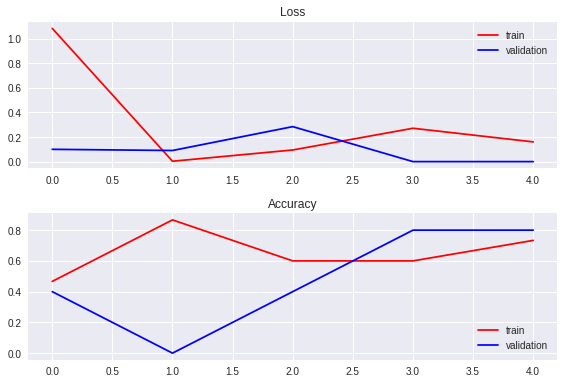

In [0]:
plt.subplot(211)
plt.title("Loss")
plt.plot(a.history["loss"], color="r", label="train")
plt.plot(a.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(a.history["acc"], color="r", label="train")
plt.plot(a.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# **Test y prueba en funcionamiento**

## **Test**

In [0]:
def load_data(name):
  image = cv2.imread('/content/drive/My Drive/TFG software/' + name + '.jpg')
  image = cv2.resize(image, (96, 96))
  image = img_to_array(image)
  return image  

def evaluate_data(name):
  values = []
  for i in range(1,classes+1):
    images = []
    if i == 1:
      images.append((load_data(name),load_data('a'),load_data('a')))
    else:
      images.append((load_data(name),load_data('z'),load_data('z')))
    data = np.array(images, dtype="float") / 255.0
    data = reshape(data,input_dim)
    values.append(model.predict([data[0],data[1],data[2]]))
  return values

In [0]:
values = []
values.append(evaluate_data('1'))  
values.append(evaluate_data('2'))  
values.append(evaluate_data('3'))  
values.append(evaluate_data('4'))  
values.append(evaluate_data('5'))  
values.append(evaluate_data('6'))  
values.append(evaluate_data('7'))  
values.append(evaluate_data('8'))  
values.append(evaluate_data('9'))  
values.append(evaluate_data('10')) 


In [0]:
for i in values:
  var = 1000
  index_var = 0
  print(i)
  for index,j in enumerate(i):
    if j <= var:
      var = j
      index_var=index
  #if index_var == 0:
    #print('Es un perro')
  #else:
    #print('Es un gato')
#print(index_var,var)

[array([[0.90051705]], dtype=float32), array([[0.7646512]], dtype=float32)]
[array([[0.29737613]], dtype=float32), array([[0.1887825]], dtype=float32)]
[array([[0.8020452]], dtype=float32), array([[0.629047]], dtype=float32)]
[array([[0.47413656]], dtype=float32), array([[0.45062965]], dtype=float32)]
[array([[0.6507756]], dtype=float32), array([[5.145962e-11]], dtype=float32)]
[array([[0.84323645]], dtype=float32), array([[0.64831984]], dtype=float32)]
[array([[0.97580475]], dtype=float32), array([[0.7569377]], dtype=float32)]
[array([[0.8974747]], dtype=float32), array([[0.3618822]], dtype=float32)]
[array([[0.83581287]], dtype=float32), array([[0.80615646]], dtype=float32)]
[array([[0.68706775]], dtype=float32), array([[0.4095326]], dtype=float32)]
